# Upload posts from Goodreads to Tumblr (UploadPosts.py)

UploadPosts.py has a few hardcoded variables in it which you can set your own tumblr's stuff. The script parses the same data the analysis below uses - go [here](https://www.goodreads.com/review/import) and press "Export your library" to get your own csv.

## Dependencies

    pytumblr
    pandas

## What it does

This script will upload the 30 last reviews it gets from the Goodreads API and puts them on the tumblr 'queue' - by default tumblr posts two posts per day from the queue. It also cleans up a few things - Goodreads specific links in the review text, unicode author and book titles, etc.

It will print something like:

    INFO:root:Uploading post for Die Ausgewanderten
    INFO:root:Uploading post for Slimer
    INFO:root:Uploading post for Never Split the Difference: Negotiating As If Your Life Depended On It
    INFO:root:Uploading post for Naked Statistics: Stripping the Dread from the Data
    INFO:root:Uploading post for King Lear
    INFO:root:Uploading post for Hamlet


And then you have 30 posts in your queue.

To set it up go to https://www.tumblr.com/settings/apps and create an app, or copy OAuth Consumer Key and OAuth Consumer Secret. Then go to https://api.tumblr.com/console/calls/user/info and enter those to receive TOKEN and TOKEN_SECRET, and enter those in the script.

After that it's just a matter of running the script:

    python UploadPosts.py

It does not support Python 3 since the pytumblr library works only under Python 2.

# Goodreads visualization

An ipython notebook to play around with Goodreads data and make some seaborn visualizations.

You can use it with your own data - go [here](https://www.goodreads.com/review/import) and press "Export your library" to get your own csv.

The text you're reading is generated from a jupyter notebook by the Makefile. If you want to run it yourself, clone the repository then run

    ipython3 notebook your_file.ipynb
    
to get the interactive version. In there, replace the path to my Goodreads exported file by yours in the ipynb file, and then run click on Cell -> Run All.

## Dependencies

* Python 3
* Ipython3/Jupyter

### Python packages

* seaborn
* pandas
* wordcloud
* nltk
* networkx
* pymarkovchain
* image (PIL inside python for some weird reason)

To install all:

    sudo pip install seaborn wordcloud nltk networkx pymarkovchain image 

## Licenses

License for reviews: CC-BY-SA 4.0
Code: MIT

OK, let's start!

## Setting up the notebook

In [1]:
% pylab inline

# for most plots
import pandas as pd
import seaborn as sns
from collections import defaultdict, Counter, OrderedDict

# for stats
import scipy.stats

# for time-related plots
import datetime
import calendar

# for word cloud
import re
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud

# for Markov chain
from pymarkovchain import MarkovChain
import pickle
import networkx as nx

sns.set_palette("coolwarm")

# change some plotting defaults
rcParams["figure.figsize"] = [14, 9]
rcParams["axes.labelsize"] = 15.0
rcParams["axes.titlesize"] = 15.0
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15
rcParams['font.size'] = 15

Populating the interactive namespace from numpy and matplotlib


## Loading the data

In [2]:
df = pd.read_csv('./goodreads_export.csv')
# keep only books that have a rating (unrated books have a rating of 0, we don't need that)
cleaned_df = df[df["My Rating"] != 0]

# Score distribution
With a score scale of 1-5, you'd expect that the average score is ~~2.5~~ 3 (since 0 is not counted) after a few hundred books (in other words, is it a normal distribution?)

('Average: 3.63', 'Median: 4.0')

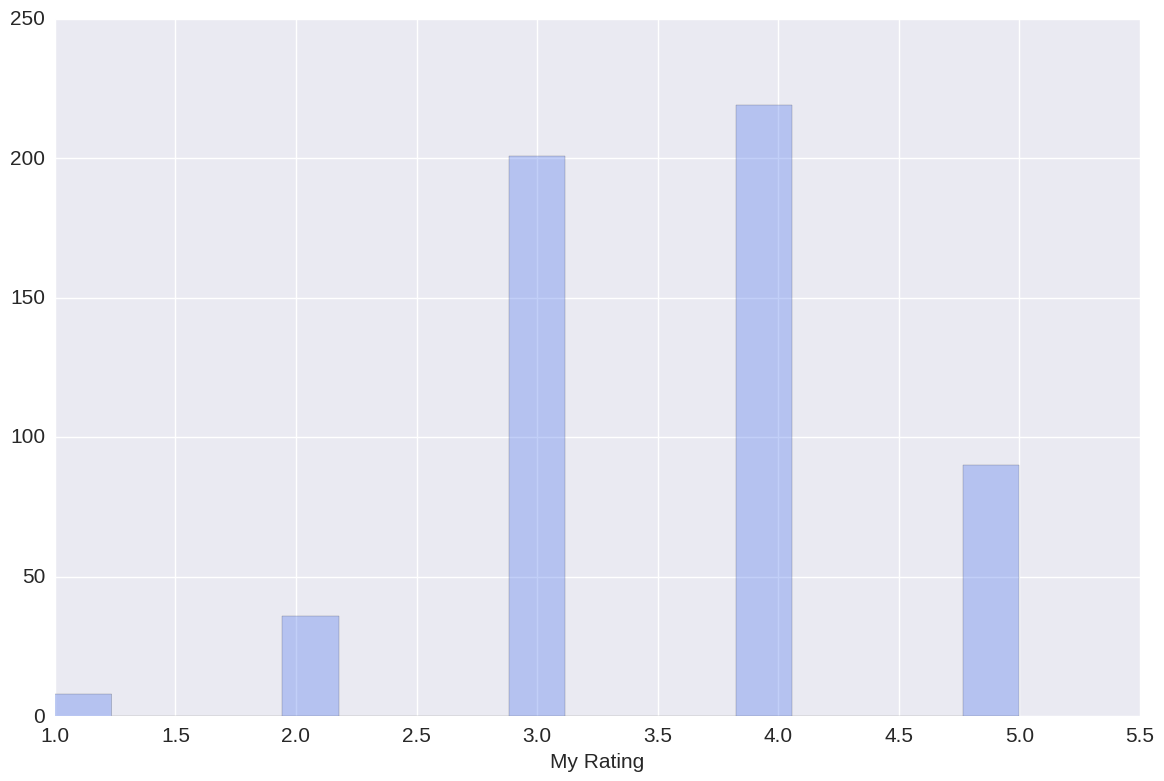

In [3]:
g = sns.distplot(cleaned_df["My Rating"], kde=False)
"Average: %.2f"%cleaned_df["My Rating"].mean(), "Median: %s"%cleaned_df["My Rating"].median()

That doesn't look normally distributed to me - let's ask Shapiro-Wilk (null hypothesis: data is drawn from normal distribution):

In [4]:
W, p_value = scipy.stats.shapiro(cleaned_df["My Rating"])
if p_value < 0.05:
    print("Rejecting null hypothesis - data does not come from a normal distribution (p=%s)"%p_value)
else:
    print("Cannot reject null hypothesis (p=%s)"%p_value)

Rejecting null hypothesis - data does not come from a normal distribution (p=1.72610573387e-20)


In my case, the data is not normally distributed (in other words, the book scores are not evenly distributed around the middle). If you think about it, this makes sense: most readers don't read perfectly randomly, I avoid books I believe I'd dislike, and choose books that I prefer. I rate those books higher than average, therefore, my curve of scores is slanted towards the right.

## plot Pages vs Ratings

Do I give longer books better scores? A minor tendency but nothing special (it's confounded by having just 5 possible numbers in ratings)

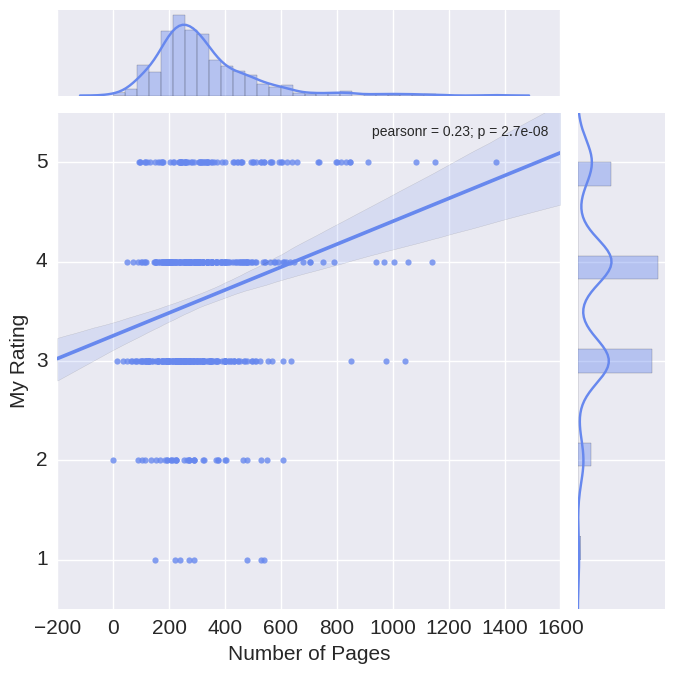

In [5]:
g = sns.jointplot("Number of Pages", "My Rating", data=cleaned_df, kind="reg", size=7, ylim=[0.5,5.5])

You can plot the "residuals" (what's left after calculating the regression line in the above plot) to see how useful a regression is - regression is useful when your residuals are randomly distributed around the y=0 line, i.e., it's a good fit.

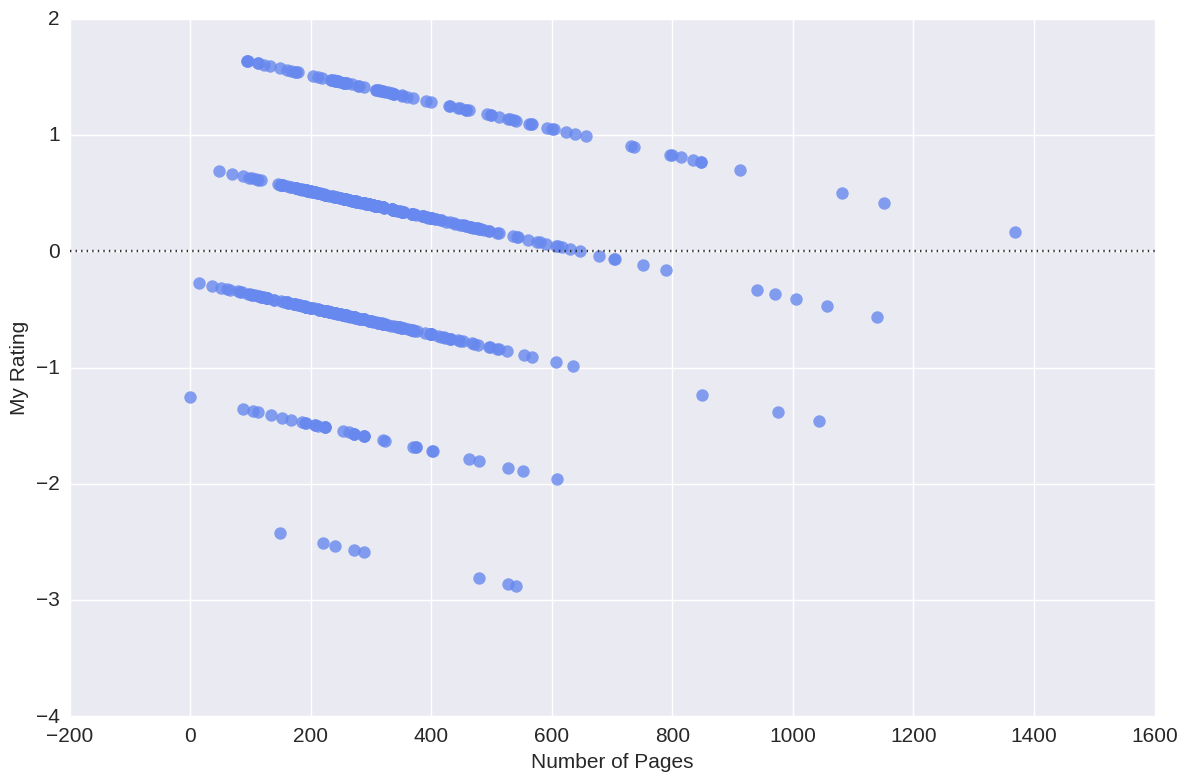

In [6]:
sns.residplot("Number of Pages", "My Rating", data=cleaned_df,
              scatter_kws={"s": 80});

That doesn't look random to me, with quite a slant towards the negative space! Regression isn't useful here.

I seem to mostly read books at around 200 to 300 pages so it's hard to tell whether I give longer books better ratings. It's also a nice example that in regards to linear regression, a p-value as tiny as this one doesn't mean much, the r-value is still bad.

***

## plot Ratings vs Bookshelves

Let's parse ratings for books and make a violin plot for the 7 categories with the most rated books!

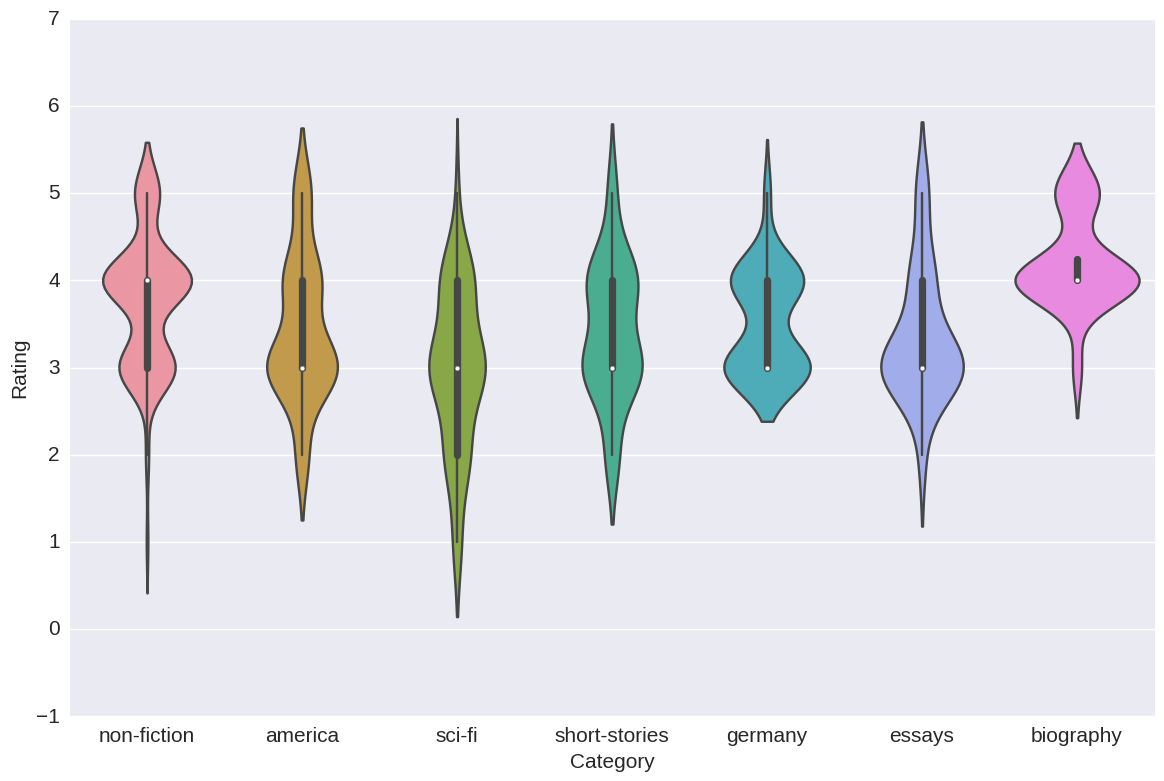

In [7]:
CATEGORIES = 7 # number of most crowded categories to plot

# we have to fiddle a bit - we have to count the ratings by category, 
# since each book can have several comma-delimited categories
# TODO: find a pandas-like way to do this

shelves_ratings = defaultdict(list) # key: shelf-name, value: list of ratings
shelves_counter = Counter() # counts how many books on each shelf

for index, row in cleaned_df.iterrows():
    my_rating = row["My Rating"]
    if my_rating == 0:
        continue
    if pd.isnull(row["Bookshelves"]):
        continue

    shelves = row["Bookshelves"].split(",")

    for s in shelves:
        # empty shelf?
        if not s: continue
        s = s.strip() # I had "non-fiction" and " non-fiction"
        shelves_ratings[s].append(my_rating)
        shelves_counter[s] += 10

names = []
ratings = []
for name, _ in shelves_counter.most_common(CATEGORIES):
    for number in shelves_ratings[name]:
        names.append(name)
        ratings.append(number)

full_table = pd.DataFrame({"Category":names, "Rating":ratings})

sns.violinplot(x = "Category", y = "Rating", data=full_table)
# older versions of seaborn throw up here with
# TypeError: violinplot() missing 1 required positional argument: 'vals'
pylab.show()

There is some *bad* SF out there.

However, the sci-fi score looks normally distributed! Let's check:

Rejecting null hypothesis - data does not come from a normal distribution (p=0.000450032006484)


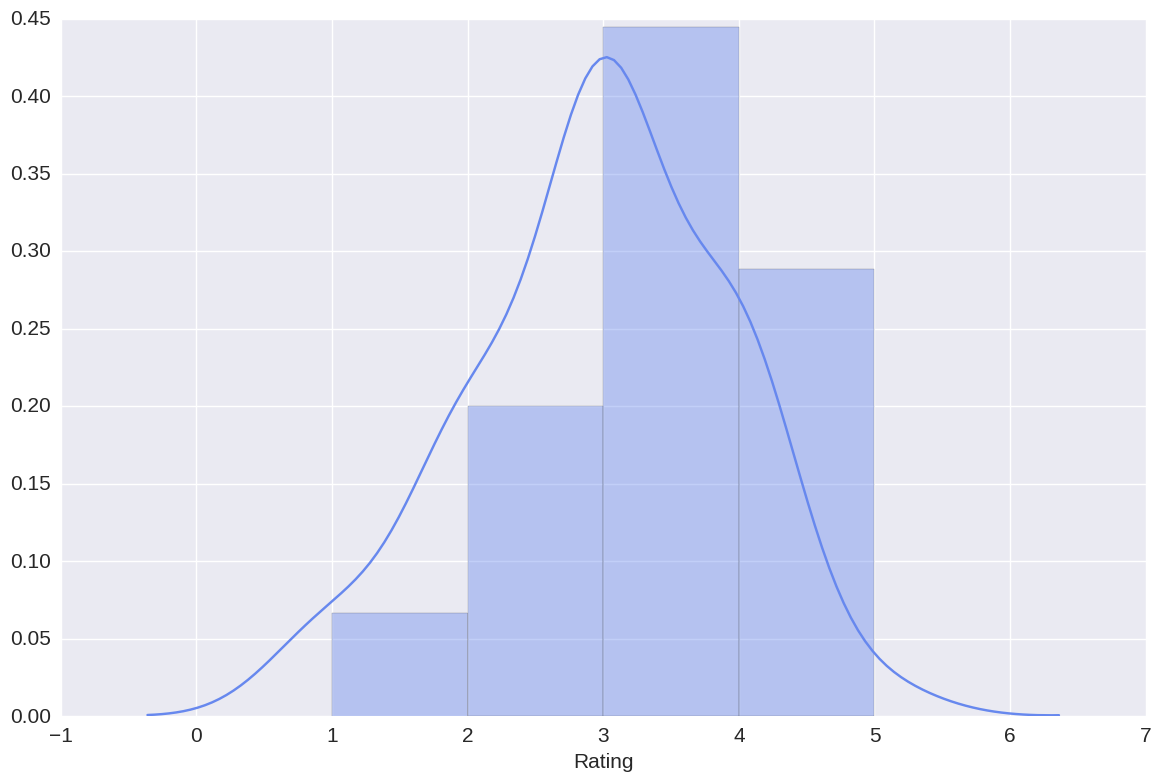

In [8]:
#print full_table
W, p_value = scipy.stats.shapiro(full_table[full_table["Category"] == "sci-fi"]["Rating"])
if p_value < 0.05:
    print("Rejecting null hypothesis - data does not come from a normal distribution (p=%s)"%p_value)
else:
    print("Cannot reject null hypothesis (p=%s)"%p_value)
sns.distplot(full_table[full_table["Category"] == "sci-fi"]["Rating"])

It does look like a close call, it's a bit skewed towards the rating of 4.

***

## plotHistogramDistanceRead.py

Let's check the "dates read" for each book read and plot the distance between books read in days - shows you how quickly you hop from book to book.

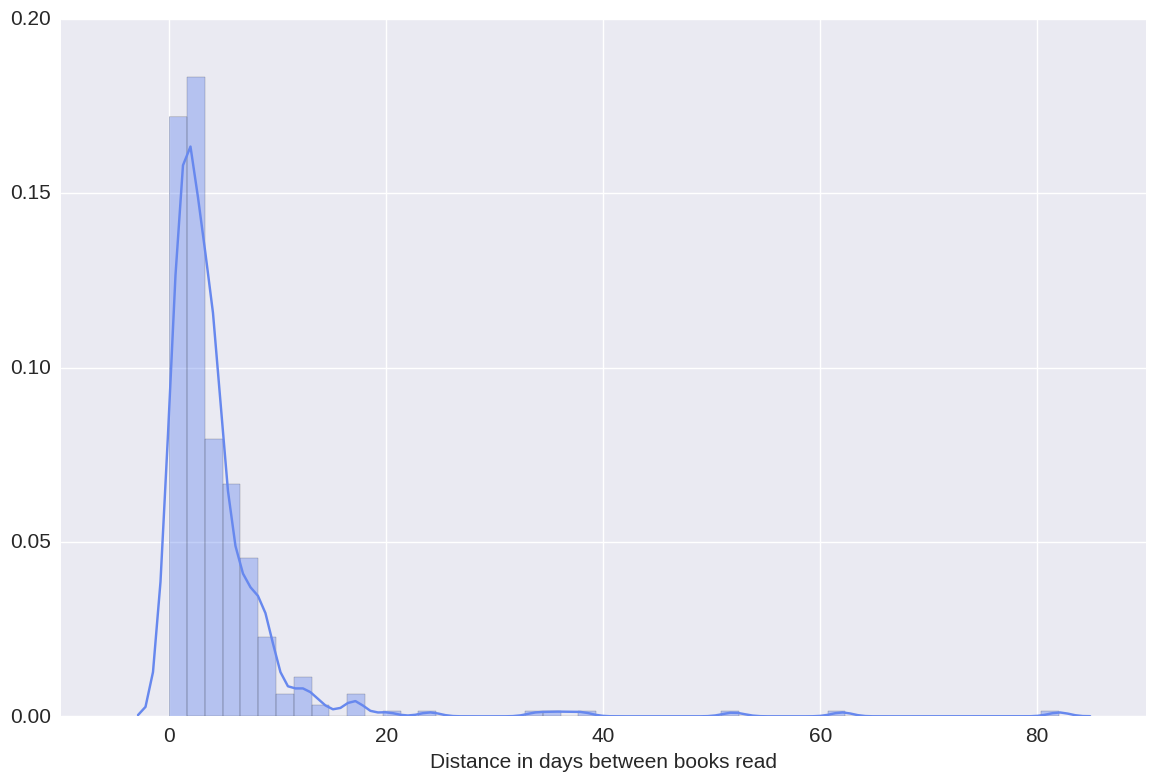

In [9]:
# first, transform to datetype and get rid of all invalid dates
dates = pd.to_datetime(cleaned_df["Date Read"])
dates = dates.dropna()
sorted_dates = sorted(dates)

last_date = None
differences = []
all_days = []
all_days_without_2012 = [] # not much goodreads usage in 2012 - remove that year
for date in sorted_dates:
    if not last_date:
        last_date = date
        if date.year != 2012:
            last_date_not_2012 = date
    difference = date - last_date
    
    days = difference.days
    all_days.append(days)
    if date.year != 2012:
        all_days_without_2012.append(days)
    last_date = date

sns.distplot(all_days, axlabel="Distance in days between books read", kde=True)
pylab.show()

Of course, sometimes I just add several at once and guesstimate the correct "date read".

I didn't use Goodreads in 2012 much so let's see how it looks like without 2012:

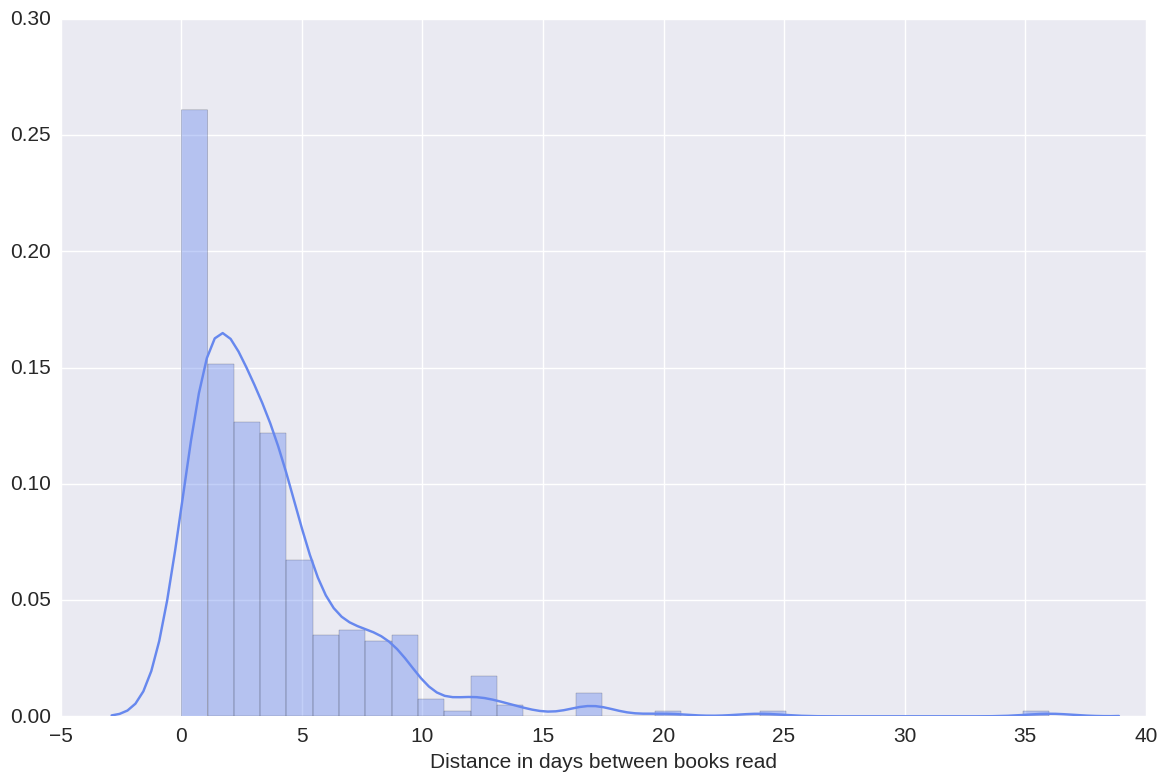

In [10]:
sns.distplot(all_days_without_2012, axlabel="Distance in days between books read")
pylab.show()

***

## plot Heatmap of dates read

Parses the "dates read" for each book read, bins them by month, and makes a heatmap to show in which months I read more than in others. Also makes a lineplot for books read, split up by year.

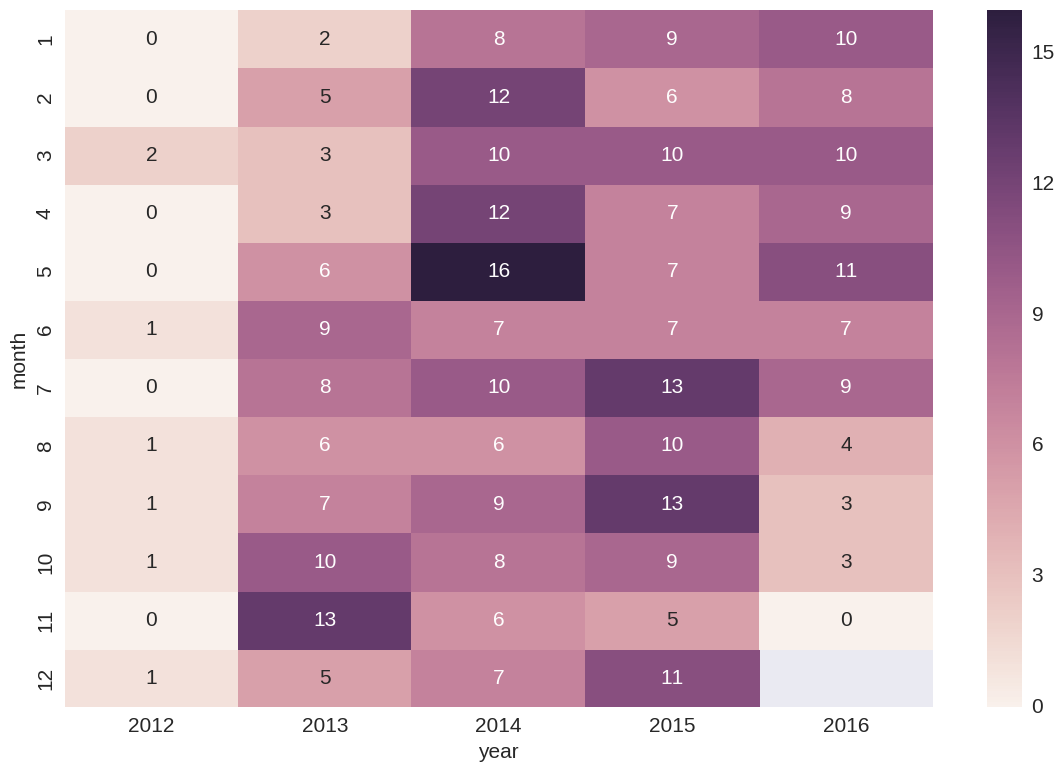

In [11]:
# we need a dataframe in this format:
# year months books_read
# I am sure there's some magic pandas function for this

read_dict = defaultdict(int) # key: (year, month), value: count of books read
for date in sorted_dates:
    this_year = date.year
    this_month = date.month
    read_dict[ (this_year, this_month) ] += 1

first_date = sorted_dates[0]

first_year = first_date.year
first_month = first_date.month

todays_date = datetime.datetime.today()
todays_year = todays_date.year
todays_month = todays_date.month

all_years = []
all_months = []
all_counts = []
for year in range(first_year, todays_year+1):
    for month in range(1, 13):
        if (year == todays_year) and month > todays_month:
            # don't count future months
            # it's 2015-12 now so a bit hard to test
            break
        this_count = read_dict[ (year, month) ]
        all_years.append(year)
        all_months.append(month)
        all_counts.append(this_count)

# now get it in the format heatmap() wants
df = pd.DataFrame( { "month":all_months, "year":all_years, "books_read":all_counts } )
dfp = df.pivot("month", "year", "books_read")

# now make the heatmap
ax = sns.heatmap(dfp, annot=True)

What happened in May 2014?

***

## Plot books read by year

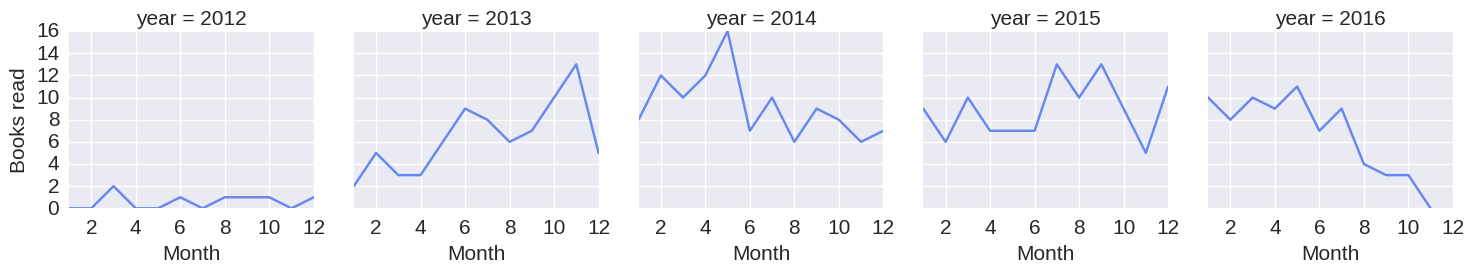

In [12]:
g = sns.FacetGrid(df, col="year", sharey=True, sharex=True) 
g.map(plt.plot, "month", "books_read")
g.set_ylabels("Books read")
g.set_xlabels("Month")
pylab.xlim(1, 12)
pylab.show()

It's nice how reading behaviour (Goodreads usage) connects over the months - it slowly in 2013, stays constant in 2014/2015, and now goes down again.

***

## plot Word Cloud


This one removes noisy words and creates a word-cloud of most commonly used words in the reviews.

You have 47492 words in 332 reviews


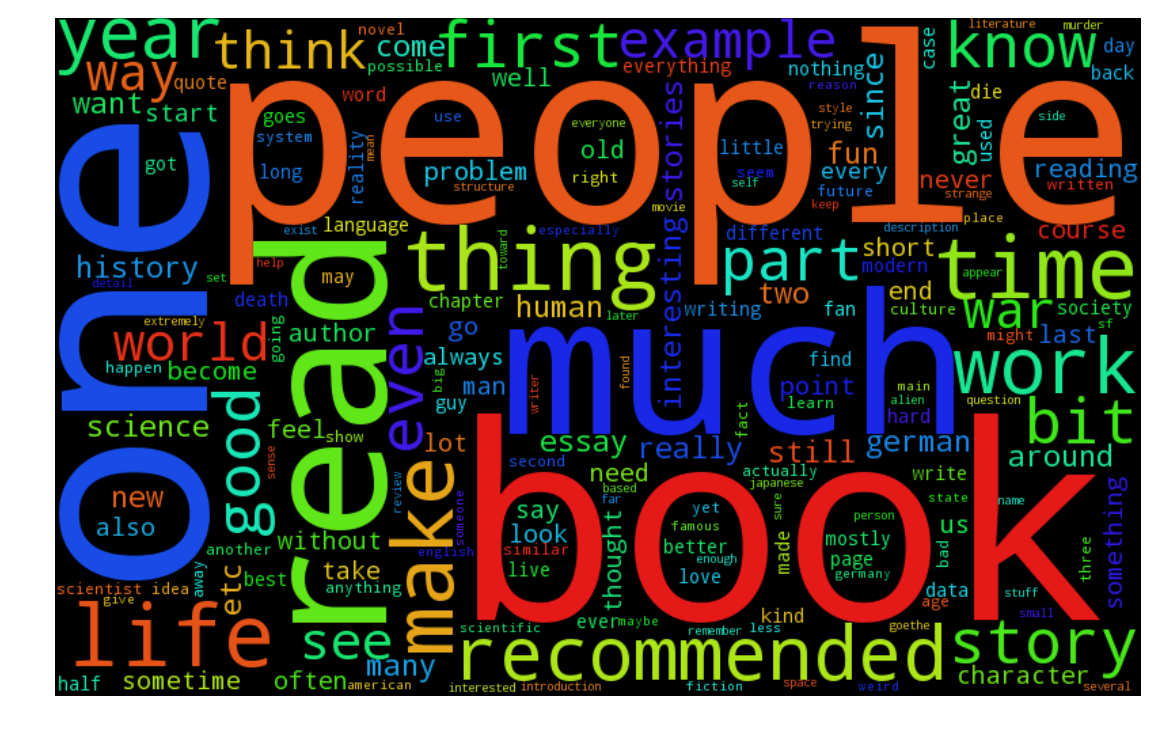

In [13]:
def replace_by_space(word):
    new = []
    for letter in word:
        if letter in REMOVE:
            new.append(' ')
        else:
            new.append(letter)
    return ''.join(new)

STOP = stopwords.words("english")
html_clean = re.compile('<.*?>')
gr_clean = re.compile('\[.*?\]')
PRINTABLE = string.printable
REMOVE = set(["!","(",")",":",".",";",",",'"',"?","-",">","_"])

all_my_words = []
all_my_words_with_stop_words = []

reviews = cleaned_df["My Review"]

num_reviews = 0
num_words = 0
for row in reviews:
    if pd.isnull(row):
        continue
    review = row.lower()
    if not review:
        # empty review
        continue
    # clean strings
    cleaned_review = re.sub(html_clean, '', review)
    cleaned_review = re.sub(gr_clean, '', cleaned_review)
    all_my_words_with_stop_words += cleaned_review
    cleaned_review = replace_by_space(cleaned_review)
    cleaned_review = "".join(filter(lambda x: x in PRINTABLE, cleaned_review))
    # clean words
    cleaned_review = cleaned_review.split()
    cleaned_review = list(filter(lambda x: x not in STOP, cleaned_review))
    num_words += len(cleaned_review)
    all_my_words += cleaned_review
    num_reviews += 1

print("You have %s words in %s reviews"%(num_words, num_reviews))

# we need all words later for the Markov chain
all_my_words_with_stop_words = ''.join(all_my_words_with_stop_words)

# WordCloud takes only string, no list/set
wordcloud = WordCloud(max_font_size=200, width=800, height=500).generate(' '.join(all_my_words))
pylab.imshow(wordcloud)
pylab.axis("off")
pylab.show()

***

## plot books read vs. week-day

Let's parse the weekday a "book read" has been added and count them

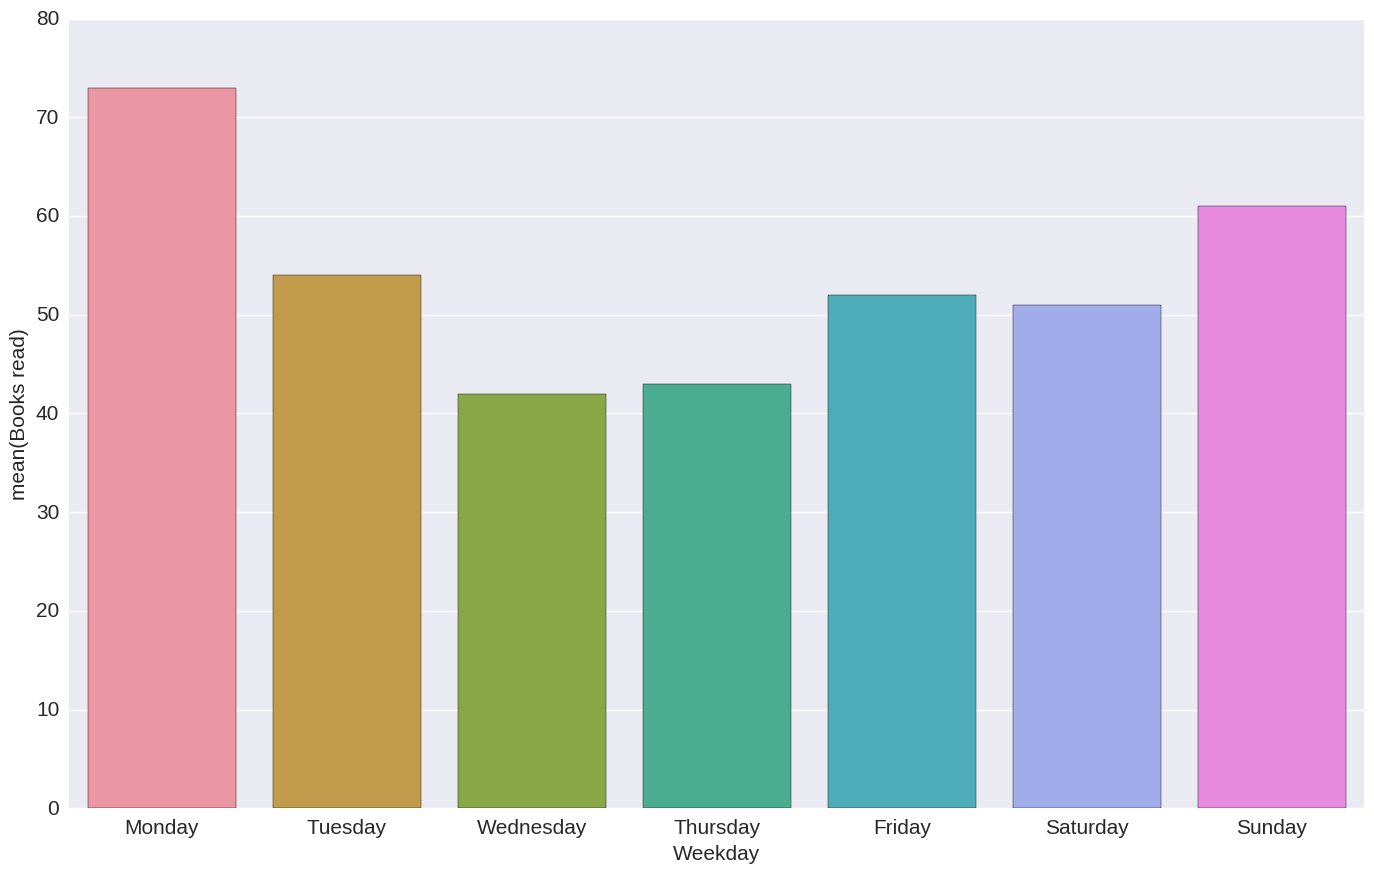

In [14]:
# initialize the dict in the correct order
read_dict = OrderedDict() # key: weekday, value: count of books read
for day in range(0,7):
    read_dict[calendar.day_name[day]] = 0

for date in sorted_dates:
    weekday_name = calendar.day_name[date.weekday()]  # Sunday
    read_dict[weekday_name] += 1

full_table = pd.DataFrame({"Weekday":list(read_dict.keys()), "Books read":list(read_dict.values())})

sns.barplot(x="Weekday", y="Books read", data=full_table)
plt.tight_layout()
plt.show()


Monday is procrastination day.

***

## Generate Reviews

Tiny script that uses a simple Markov Chain and the review text as created by plotWordCloud.py to generate new reviews.
Some examples:

* “natural” death, almost by definition, means something slow, smelly and painful
* a kind of cyborg, saved by the master was plagued in his work - for that i'm getting angry again just typing this - some are of exactly the opposite, and of black holes
* american actress wikipedia tells me) once said: "a critic never fights the battle; they just read, focus on his own goshawk 50 years
* he always wanted to do something, and i don't know how accurate he is
* not recommended for: people who, if they can't be reduced to a small essay
* machiavelli summarises quite a bit like reading a 120 pages summary of the helmet of horror
* - no supervisor, no grant attached to a beautiful suicide and now i cleared my mind of circe's orders -cramping my style, urging me not to write the paper
* not being focused on useless mobile apps, but on medical companies that treat death as a sign of dissent
* the harassment of irs-personnel to get into the dark cave

*why does this work so well*

This script also creates a graph of probabilities for word connections for the word "translation", the thicker the edge between the nodes, the higher the probability.

it's all very "standard" fantasy/sf from there


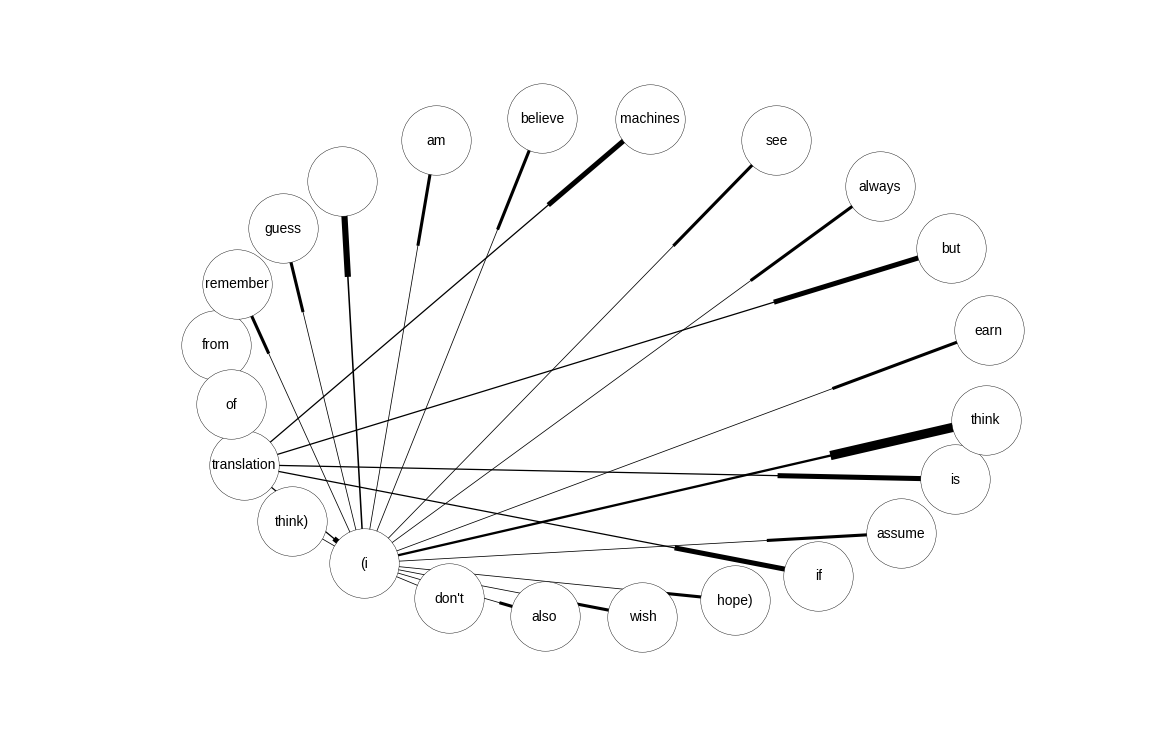

In [15]:
mc = MarkovChain(dbFilePath='./markov_db')
mc.generateDatabase(all_my_words_with_stop_words)

print(mc.generateString())

mc.dumpdb()

# a key in the datbase looks like:
# ('when', 'you') defaultdict(<function _one at 0x7f5c843a4500>, 
# {'just': 0.06250000000059731, 'feel': 0.06250000000059731, 'had': 0.06250000000059731, 'accidentally': 0.06250000000059731, ''love': 0.06250000000059731, 'read': 0.06250000000059731, 'see': 0.06250000000059731, 'base': 0.06250000000059731, 'know': 0.12499999999641617, 'have': 0.12499999999641617, 'were': 0.06250000000059731, 'come': 0.06250000000059731, 'can't': 0.06250000000059731, 'are': 0.06250000000059731})
# so 'just' follows after 'when you' with 6% probability

db = pickle.load(open('./markov_db', 'rb'))
# let's get a good node
#for key in db:
#    # has in between 5 and 10 connections
#    if len(db[key]) > 5 and (len(db[key]) < 10):
#        if len(set(db[key].values())) > 2:
#            print key, set(db[key].values())

# manually chosen from above
good_key = ('translation',)
values = db[good_key]

# create the graph

G = nx.DiGraph()
good_key = str(good_key[0])
G.add_node(good_key)
G.add_nodes_from(values.keys())
# get the graph for one of the connected nodes
# we go only one step deep - anything more and we'd better use recursion (but graph gets ugly then anyway)
for v in values:
    if (v,) in db and (len(db[(v,)]) < 20):
        G.add_nodes_from(db[(v,)].keys())
        for partner in db[(v,)]:
            edge_weight = db[(v,)][partner]
            G.add_weighted_edges_from([ (v, partner, edge_weight) ])
        # for now, only add one
        break

# now add the edges of the "original" graph around "translation"
for partner in values:
    edge_weight = values[partner]
    G.add_weighted_edges_from([ (good_key, partner, edge_weight) ])

pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, node_color = 'white', node_size = 2500)

# width of edges is based on probability * 10
for edge in G.edges(data=True):
    nx.draw_networkx_edges(G, pos, edgelist = [(edge[0], edge[1])], width = edge[2]['weight']*10)

nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
pylab.axis('off')
pylab.show()

I really wonder why it always forces the circular layout - it should connect from "translation" to "(i" which in turn connects to a few nodes.

***

## Some other ideas

- Some people on goodreads have complained that their reviews disappear and I feel (but don't know) that I lost at least one, this tracks my exported CSV to check whether it actually happens. So far I haven't observed it.
- ~~Write automated parser that exports reviews to html/epub/tumblr/blogger/wordpress etc.~~ support for this was added to goodreads)
- ~~cron job which automatically pulls exported CSV from https://www.goodreads.com/review_porter/goodreads_export.csv (login a bit weird esp. with Facebook login, use API instead? Needs dev key, but easier to do /review/list.xml=USERID than to play Red Queen with Facebook's oauth)~~
- various visualization things in regards to language use